<a href="https://colab.research.google.com/github/osgeokr/mmarn-data-capacity-2025/blob/main/8__ndice_de_algas_flotantes_de_sargazo_basado_en_aviso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica de análisis del índice de algas flotantes (Sargassum) basado en AVISO+

AVISO+ proporciona datos del **Índice Normalizado de Algas Flotantes (NFAI: Normalized Floating Algae Index)**,
los cuales se utilizan en este ejercicio para analizar temporalmente la presencia de sargazo en una región específica.  
Esta práctica abarca desde la descarga de datos, la visualización de mapas en serie temporal,
hasta el análisis del total diario del índice de algas.

In [18]:
!pip install -U -q leafmap rasterio rioxarray netcdf4 localtileserver

In [19]:
import requests, os
import xarray as xr
import numpy as np
import leafmap
import rasterio
import rioxarray
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pathlib import Path
from datetime import datetime

from google.colab import output
output.enable_custom_widget_manager()

## Configuración de AVISO+ NCSS y definición del área de análisis

En esta sección se configuran la URL necesaria para las solicitudes al API NCSS de AVISO+,
las credenciales de usuario, el área de análisis (Bounding Box) y el período temporal.  
Asimismo, se especifica la lista de variables a utilizar (`nfai_mean`, `nfai_max`, `nfai_min`, `nfai_nbpts`).

In [20]:
# URL de solicitud NCSS (NetCDF Subset Service)
NCSS_URL = "https://tds-odatis.aviso.altimetry.fr/thredds/ncss/grid/dataset-sargassum-cls-merged-msi-oli-global-lr"

# Productos de detección de Sargassum
# Si no está registrado en AVISO+: https://www.aviso.altimetry.fr/en/data/data-access/registration-form.html
# Si ya tiene una cuenta AVISO+: https://www.aviso.altimetry.fr/en/my-aviso-plus.html

# Credenciales de autenticación
# Reemplace 'your-username' y 'your-password' con la información real de su cuenta AVISO.
USER = os.getenv("AVISO_USER", "bhyu@knps.or.kr")
PW   = os.getenv("AVISO_PW",   "SgeEoU")

# Área de análisis (Bounding Box)
west, east, south, north = -68.92405248166772, -68.40695965660555, 17.99922814815082, 18.479964791218272
BBOX = dict(north=north, south=south, east=east, west=west)

# Período de análisis
YEAR, MONTH = 2025, 7
time_start = f"{YEAR}-{MONTH:02d}-01T00:00:00Z"
time_end   = f"{YEAR}-{MONTH:02d}-31T23:59:59Z"

# Lista de variables a solicitar
# nfai_mean  : Promedio diario del índice NFAI dentro de una celda de la cuadrícula de tamaño bin_size°
# nfai_max   : Valor máximo diario del índice NFAI dentro de una celda de la cuadrícula de tamaño bin_size°
# nfai_min   : Valor mínimo diario del índice NFAI dentro de una celda de la cuadrícula de tamaño bin_size°
# nfai_nbpts : Número de píxeles de NFAI presentes en la celda de la cuadrícula de tamaño bin_size°
VARS = ["nfai_mean", "nfai_max", "nfai_min", "nfai_nbpts"]

## Definición de la función para descargar NetCDF

La siguiente función envía una solicitud GET al servidor NCSS de AVISO+ para descargar un archivo NetCDF.  
Incluye la generación de parámetros de solicitud, autenticación mediante sesión, verificación del formato de respuesta y el proceso de guardado del archivo.

In [21]:
def fetch_ncss(url: str, out_path):
    """Descargar un archivo NetCDF desde una URL NCSS para un área/período/variables dados"""
    params = {
        "var": VARS,
        "north": BBOX["north"],
        "south": BBOX["south"],
        "east":  BBOX["east"],
        "west":  BBOX["west"],
        "horizStride": 1,
        "time_start": time_start,
        "time_end":   time_end,
        "accept": "netcdf4",
    }

    with requests.Session() as s:
        s.auth = (USER, PW)
        r = s.get(url, params=params, timeout=180)
        r.raise_for_status()
        ctype = r.headers.get("Content-Type", "")
        if "netcdf" not in ctype.lower():
            raise RuntimeError(f"El servidor devolvió una respuesta que no es NetCDF: {ctype}")
        out_path.write_bytes(r.content)

    return out_path

## Descarga de datos NetCDF

Utilizamos la función definida anteriormente para descargar el archivo NetCDF y verificamos que se haya guardado correctamente.

In [22]:
nc_path = Path(f"{YEAR}_{MONTH:02d}_nfai.nc")
saved = fetch_ncss(NCSS_URL, nc_path)
print(f"[Save complete] {saved}")

[Save complete] 2025_07_nfai.nc


## Inspección de la estructura del archivo NetCDF

Se utiliza **xarray** para inspeccionar la estructura interna del archivo NetCDF.  
En esta sección se revisan los siguientes elementos:

- Estructura general de variables
- Tamaño de las dimensiones `time`, `latitude`, `longitude`
- Lista de fechas (dimensión `time`)
- Información sobre la resolución de latitud y longitud

Esta información servirá como base para la posterior conversión a GeoTIFF y para el análisis de series temporales.

In [23]:
# Abrir archivo NetCDF
ds = xr.open_dataset(nc_path, engine="h5netcdf")

print("=== Resumen del dataset ===")
print(ds)

# Verificar la dimensión temporal
time_dim = None
for cand in ["time", "Time", "t"]:
    if cand in ds.dims:
        time_dim = cand
        break

if time_dim:
    n_layers = ds.sizes[time_dim]
    print(f"\nEste archivo contiene un total de {n_layers} capas temporales.")
    print("Lista de tiempos:", ds[time_dim].values)
else:
    print("\nEste archivo no contiene una dimensión temporal.")

ds.close()

=== Resumen del dataset ===
<xarray.Dataset> Size: 36MB
Dimensions:     (time: 32, latitude: 193, longitude: 208)
Coordinates:
  * time        (time) datetime64[ns] 256B 2025-07-01 2025-07-02 ... 2025-08-01
  * latitude    (latitude) float64 2kB 18.0 18.0 18.0 ... 18.48 18.48 18.48
  * longitude   (longitude) float64 2kB -68.92 -68.92 -68.92 ... -68.41 -68.41
Data variables:
    nfai_mean   (time, latitude, longitude) float64 10MB ...
    nfai_max    (time, latitude, longitude) float64 10MB ...
    nfai_min    (time, latitude, longitude) float64 10MB ...
    nfai_nbpts  (time, latitude, longitude) float32 5MB ...
Attributes: (12/23)
    cdm_data_type:            Grid
    instrument:               MSI, OLI
    platform:                 Sentinel-2A, Sentinel 2-B, Landsat-8 and Landsat-9
    summary:                  This dataset provides statistics of the normali...
    comment:                  MSI data are provided by ESA through the Copern...
    institution:              Collecte Loc

## Verificación de los datos originales para una fecha específica

Seleccione `nfai_nbpts` u otra variable para revisar las estadísticas de una fecha determinada (time slice).  
Revise el valor mínimo, máximo, presencia de valores nodata y el número de NaN para identificar posibles anomalías en los datos.

In [24]:
with xr.open_dataset(nc_path, engine="h5netcdf") as ds:
    var_name = "nfai_nbpts"
    date_str = "2025-07-10"
    date = np.datetime64(date_str)

    da_raw = ds[var_name].sel(time=date)

    print("Valores mínimos/máximos de los datos originales:")
    print("min:", float(da_raw.min().values))
    print("max:", float(da_raw.max().values))

    # Verificar si existen muchos valores NaN
    print("Número de valores NaN:", int(np.isnan(da_raw.values).sum()))

Valores mínimos/máximos de los datos originales:
min: -5000.0
max: 1.0
Número de valores NaN: 23830


## Definición de la función para convertir NetCDF → GeoTIFF

La siguiente función selecciona una variable para una fecha específica y la convierte en un archivo GeoTIFF.

El flujo de procesamiento es el siguiente:

- Selección de la fecha
- Enmascaramiento de valores nodata
- Asignación del sistema de coordenadas (EPSG:4326)
- Unificación de los nombres de coordenadas (latitude/longitude → y/x)
- Guardado del GeoTIFF utilizando rioxarray

El archivo se guarda con el nombre: `{nombre_variable}_{fecha}.tif`.

In [25]:
def nfai_nc_to_tiff(nc_path, var_name, date_str, out_dir=".", default_nodata=-5000.0):
    """
    Función para convertir una variable NFAI de NetCDF → GeoTIFF y guardarla.

    Parámetros
    ----------
    nc_path : str o Path
        Ruta del archivo NetCDF
    var_name : str
        Uno de: 'nfai_mean', 'nfai_max', 'nfai_min', 'nfai_nbpts'
    date_str : str
        Fecha en formato 'YYYY-MM-DD'
    out_dir : str o Path
        Carpeta de salida para el GeoTIFF
    default_nodata : float
        Valor nodata por defecto si el NetCDF no contiene _FillValue

    Retorna
    -------
    Path : Ruta del archivo GeoTIFF generado
    """

    date = np.datetime64(date_str)
    nc_path = Path(nc_path)
    out_dir = Path(out_dir)

    with xr.open_dataset(nc_path, engine="h5netcdf") as ds:
        nodata = float(ds[var_name].attrs.get("_FillValue", default_nodata))

        da = (
            ds[var_name]
            .sel(time=date)
            .where(lambda x: x != nodata)
            .rename(latitude="y", longitude="x")
            .sortby("y", ascending=False)
            .rio.write_crs("EPSG:4326")
            .rio.write_nodata(nodata)
            .fillna(nodata)
            .load()
        )

        # Nombre de banda
        da.name = var_name

    # Ruta de salida
    tif_path = out_dir / f"{var_name}_{date_str}.tif"

    # Guardar GeoTIFF
    da.rio.to_raster(tif_path, overwrite=True)

    print(f"[Saved] {tif_path}")

## Ejecución de la conversión a GeoTIFF para una fecha específica

Se utiliza la función de conversión definida para generar un GeoTIFF correspondiente a una fecha de ejemplo (por ejemplo, 2025-07-10) y se verifica la ruta del archivo generado.

In [26]:
nfai_nc_to_tiff("2025_07_nfai.nc", "nfai_nbpts", "2025-07-10")

[Saved] nfai_nbpts_2025-07-10.tif


## Visualización individual con Leafmap

Se visualiza el archivo GeoTIFF convertido utilizando Leafmap.  
Es posible superponer los datos de NFAI sobre mapas satelitales de Esri o Google para su inspección.

In [27]:
tif_path = "nfai_nbpts_2025-07-10.tif"

# Crear el mapa
m = leafmap.Map(width="700px", height="400px", zoom=10)
m.add_basemap("Esri.WorldImagery")
m.add_raster(
    str(tif_path),
    colormap="viridis",
    vmin=0, vmax=1,
    nodata=-5000.0,
    opacity=1.0,
    layer_name=f"{var_name} {date_str}",
    zoom_to_layer=True,
)
m

Map(center=[18.240000000000002, -68.66624999999999], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Extracción de la lista completa de fechas

Se lee la dimensión `time` del archivo NetCDF y se convierte a cadenas de fecha en formato `YYYY-MM-DD`.  
Esta lista de fechas se utilizará para la generación automática de archivos TIFF y para crear un mapa con control deslizante temporal.

In [28]:
# Comprobación de la lista de fechas en el archivo NC
with xr.open_dataset(nc_path, engine="h5netcdf") as ds:
    times = ds["time"].values

start_date_str = np.datetime_as_string(times[0], unit="D")
end_date_str   = np.datetime_as_string(times[-1], unit="D")

print("Fecha de inicio:", start_date_str)
print("Fecha de fin:", end_date_str)
print("Número total de pasos temporales:", len(times))

Fecha de inicio: 2025-07-01
Fecha de fin: 2025-08-01
Número total de pasos temporales: 32


## Generación automática de GeoTIFF para todas las fechas

Se recorre la dimensión temporal (`time`) y se generan automáticamente archivos TIFF para cada fecha.  
Los GeoTIFF resultantes se guardan en la carpeta de salida (`out_dir`) y pueden utilizarse para la creación de mapas de series temporales.

In [29]:
nc_path = "2025_07_nfai.nc"
var_name = "nfai_nbpts"
out_dir = Path("nfai_nbpts")
out_dir.mkdir(exist_ok=True)

# Guardar GeoTIFF por cada fecha
for t in times:
    date_str = np.datetime_as_string(t, unit="D")
    nfai_nc_to_tiff(
        nc_path=nc_path,
        var_name=var_name,
        date_str=date_str,
        out_dir=out_dir,
        default_nodata=-5000.0,
    )

[Saved] nfai_nbpts/nfai_nbpts_2025-07-01.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-02.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-03.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-04.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-05.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-06.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-07.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-08.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-09.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-10.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-11.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-12.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-13.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-14.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-15.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-16.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-17.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-18.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-19.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-20.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-21.tif
[Saved] nfai_nbpts/nfai_nbpts_2025-07-22.tif
[Saved] nf

In [30]:
# Lista de fechas
dates = ds["time"].dt.strftime("%Y-%m-%d").values.tolist()
print(dates)

['2025-07-01', '2025-07-02', '2025-07-03', '2025-07-04', '2025-07-05', '2025-07-06', '2025-07-07', '2025-07-08', '2025-07-09', '2025-07-10', '2025-07-11', '2025-07-12', '2025-07-13', '2025-07-14', '2025-07-15', '2025-07-16', '2025-07-17', '2025-07-18', '2025-07-19', '2025-07-20', '2025-07-21', '2025-07-22', '2025-07-23', '2025-07-24', '2025-07-25', '2025-07-26', '2025-07-27', '2025-07-28', '2025-07-29', '2025-07-30', '2025-07-31', '2025-08-01']


In [31]:
# Lista de rutas de imágenes
images = [str(out_dir / f"{var_name}_{d}.tif") for d in dates]

print(images)

['nfai_nbpts/nfai_nbpts_2025-07-01.tif', 'nfai_nbpts/nfai_nbpts_2025-07-02.tif', 'nfai_nbpts/nfai_nbpts_2025-07-03.tif', 'nfai_nbpts/nfai_nbpts_2025-07-04.tif', 'nfai_nbpts/nfai_nbpts_2025-07-05.tif', 'nfai_nbpts/nfai_nbpts_2025-07-06.tif', 'nfai_nbpts/nfai_nbpts_2025-07-07.tif', 'nfai_nbpts/nfai_nbpts_2025-07-08.tif', 'nfai_nbpts/nfai_nbpts_2025-07-09.tif', 'nfai_nbpts/nfai_nbpts_2025-07-10.tif', 'nfai_nbpts/nfai_nbpts_2025-07-11.tif', 'nfai_nbpts/nfai_nbpts_2025-07-12.tif', 'nfai_nbpts/nfai_nbpts_2025-07-13.tif', 'nfai_nbpts/nfai_nbpts_2025-07-14.tif', 'nfai_nbpts/nfai_nbpts_2025-07-15.tif', 'nfai_nbpts/nfai_nbpts_2025-07-16.tif', 'nfai_nbpts/nfai_nbpts_2025-07-17.tif', 'nfai_nbpts/nfai_nbpts_2025-07-18.tif', 'nfai_nbpts/nfai_nbpts_2025-07-19.tif', 'nfai_nbpts/nfai_nbpts_2025-07-20.tif', 'nfai_nbpts/nfai_nbpts_2025-07-21.tif', 'nfai_nbpts/nfai_nbpts_2025-07-22.tif', 'nfai_nbpts/nfai_nbpts_2025-07-23.tif', 'nfai_nbpts/nfai_nbpts_2025-07-24.tif', 'nfai_nbpts/nfai_nbpts_2025-07-25.tif',

## Creación de un mapa de series temporales con control deslizante de tiempo en Leafmap

En esta sección se utiliza la función `add_time_slider` de Leafmap para visualizar en el mapa los GeoTIFF diarios como una serie temporal.  
Al mover el control deslizante, se actualiza automáticamente el TIFF del índice de *Sargassum* correspondiente a la fecha seleccionada.

In [35]:
m = leafmap.Map(projection="globe", width="700px", height="400px")
m.add_basemap("Esri.WorldImagery")
m.add_time_slider(
    images,
    labels=dates,
    colormap="viridis",
    vmin=0, vmax=1,
    nodata=-5000.0,
    opacity=1.0,
    zoom_to_layer = True
)
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Cálculo del total diario de `nfai_nbpts`

Se calcula el total diario de `nfai_nbpts` a partir del archivo NetCDF.

- Exclusión de valores nodata  
- Suma en las direcciones de latitud y longitud  
- Generación del total diario (`daily_sum`) por fecha  

Este total puede utilizarse para cuantificar los cambios relativos en la distribución de *Sargassum* a lo largo del tiempo.

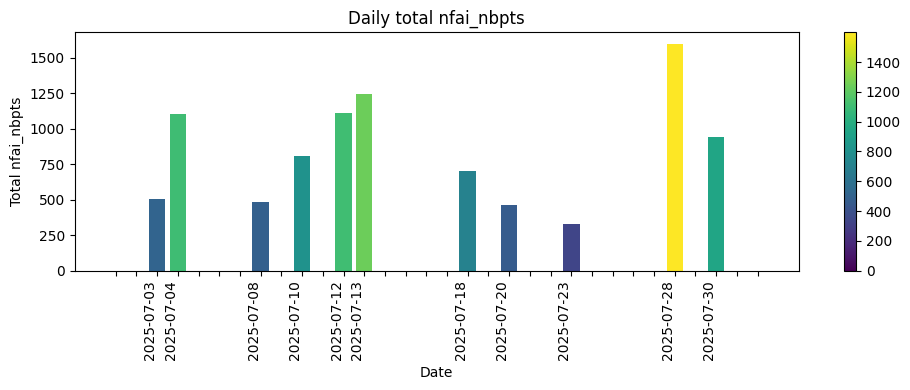

In [33]:
# Calcular el total diario de nfai_nbpts a partir del archivo NC
with xr.open_dataset(nc_path, engine="h5netcdf") as ds:
    var_name = "nfai_nbpts"
    da = ds[var_name]

    # Obtener el valor nodata (usar -5000.0 si no existe)
    nodata = float(da.attrs.get("_FillValue", -5000.0))

    # Utilizar solo valores válidos (excluyendo nodata)
    da_valid = da.where(da != nodata)

    # Sumar en las direcciones de latitud/longitud → número total de píxeles por fecha
    daily_sum = da_valid.sum(dim=["latitude", "longitude"])

    # Cadenas de fecha para el eje X
    dates = ds["time"].dt.strftime("%Y-%m-%d").values

vals = daily_sum.values

# Normalize & Colormap
norm = colors.Normalize(vmin=vals.min(), vmax=vals.max())
cmap = cm.get_cmap("viridis")
colors_list = cmap(norm(vals))

# Crear Figure & Axes
fig, ax = plt.subplots(figsize=(10, 4))

# Bar Plot
bars = ax.bar(dates, vals, color=colors_list)

# Mostrar etiqueta solo en las fechas con valor
xtick_labels = [d if v > 0 else "" for d, v in zip(dates, vals)]

ax.set_xticks(range(len(dates)))
ax.set_xticklabels(xtick_labels, rotation=90, ha="right")

ax.set_xlabel("Date")
ax.set_ylabel("Total nfai_nbpts")
ax.set_title("Daily total nfai_nbpts")

# Colorbar
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

plt.tight_layout()
plt.show()